It looks like I fell for the old trap of getting fascinated by a new toy/method without trying to understand how to do things better. My experiments with 1D and 2D convolutional neural networks for the 18 class problem didn't go too well for a bunch of reasons that I haven't quite been able to disentangle yet. I still need to go back to the unsuccessful networks and understand which kinds of examples they worked for and which ones they didnt. But....right now after some discussions with Neetas, I realise that it's better to go simpler and use some manually engineered features from the audio to train the networks in this classification task. 

### The logic:


In [1]:
from multiprocessing  import Pool

import matplotlib.pyplot as plt 
plt.rcParams['agg.path.chunksize'] = 10000
import numpy as np 
np.random.seed(151)

In [2]:
np.warnings.filterwarnings('ignore')

In [3]:
from  make_CFcall_training_data import generate_audio_snippet, generate_audio_and_calc_features
from  make_CFcall_training_data import calculate_snippet_features, calc_features_fft_pll, make_100_examples_fftfeatures

In [4]:
example = generate_audio_snippet('mm1')

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


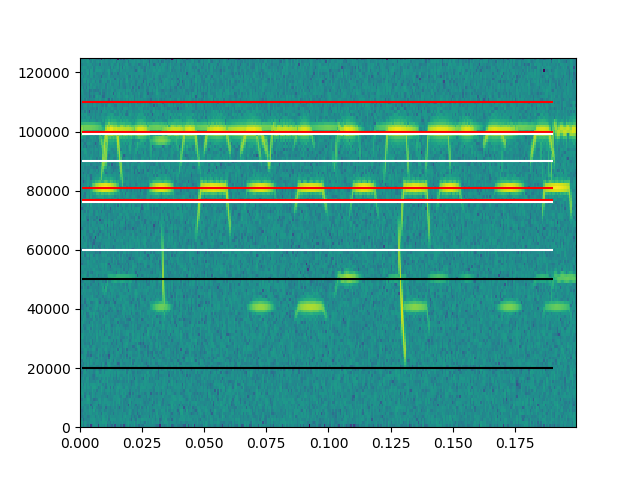

In [6]:
plt.figure()
plt.specgram(example, Fs=250000, NFFT=250, noverlap=100);

In [7]:
def plot_feature_bands():
    plt.hlines([100000.001,110000], 0.001,0.19,'r') # EuMe CF band
    plt.hlines([90000.001,99000], 0.001,0.19,'w') # EuMe FM band
    plt.hlines([77000.001,81000],0.001,0.19,'r') # Ferrum Cfband
    plt.hlines([60000.001,76000],0.001,0.19,'w') # Ferrum FM band
    plt.hlines([20000,50000],0.001,0.19,'k') # Myotis FM band
plot_feature_bands()

My plan is to have four 'channels' that will cover the important frequency bands that may be useful features. 

1)  EuMe Cf band, 100-106 kHz

2)  EuMe FM band, 90-99 kHz

3)  Ferrum CF band, 77-81 kHz

4)  Ferrum FM band, 60-77 kHz

5)  Myotis FM band, 20-50 kHz

In [8]:
eg_cases= {'mm1' : generate_audio_snippet('mm1'),
           '110' : generate_audio_snippet('110'),
           '111' : generate_audio_snippet('111'),
           '1m1' : generate_audio_snippet('1m1'),
};

###  Visualising what the features look like:

In [9]:
def plot_all_features(features):
    label_names = ['eume_cf', 'eume_fm', 'ferrum_cf', 'ferrum_fm', 'myotis_fm']
    for i in range(5):
        one_feature  = features[:,i]
        one_feature *= 1/np.max(one_feature)
        plt.plot(one_feature, label=label_names[i])

<IPython.core.display.Javascript object>


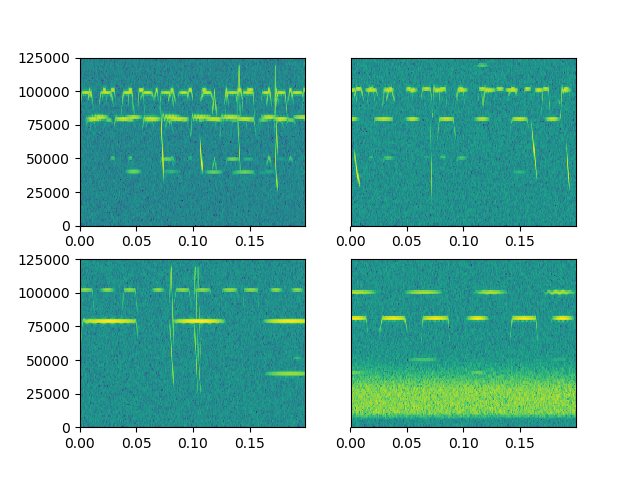

([], <a list of 0 Text yticklabel objects>)

In [10]:
plt.figure()
plt.subplot(221)
plt.specgram(eg_cases['mm1'], Fs=250000);
plt.subplot(222)
plt.specgram(eg_cases['1m1'], Fs=250000);plt.yticks([])
plt.subplot(223)
plt.specgram(eg_cases['111'], Fs=250000);
plt.subplot(224)
plt.specgram(eg_cases['110'], Fs=250000);plt.yticks([])

In [11]:
features = { situation : calculate_snippet_features(audio, 250)  for situation, audio in eg_cases.iteritems()}

<IPython.core.display.Javascript object>


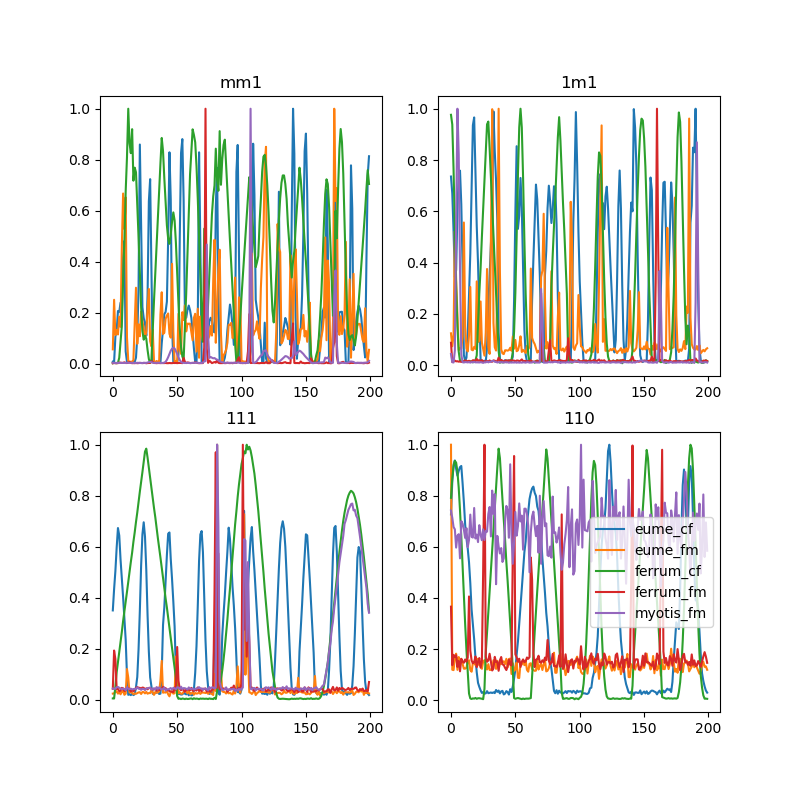

In [12]:
plt.figure(figsize=(8,8))
num = [221,222,223,224] 
for i, case in enumerate(['mm1','1m1','111','110']):
    plt.subplot(num[i])
    plt.title(case)
    plot_all_features(features[case])
plt.legend()

### Preparing the features for the audio snippets:
After having created all of the audio snippets in the previous notebook ('Developing the spectrogram...'), I'm not going to calculate the features from audio snippets with a resolution of 1ms (250samples chunksize). This will give rise to a 5 x 200 np.array for each audio snippet. 

In [13]:
features[case].shape

(200, 5)

# load the audio snippets : 
all_audio = np.load('training_data/sim_audio_snippets.npy', mmap_mode='r+')

# load the one-hot coded labels:
all_labels = np.load('training_data/sim_audio_labels.npy', mmap_mode='r+')

all_audio.shape

all_labels.shape

# calculate the features by splitting the array into 4 chunks and then doing the calculations parallely 
from multiprocessing import Pool
pool = Pool(4)

all_audio_split = np.array_split(all_audio, 4)

all_audio_split[3].shape

%%time
allaudio_features_split = pool.map(calc_features_pll, all_audio_split)

allaudio_features_split[0].shape

allaudio_features = np.float16(np.concatenate(allaudio_features_split))

allaudio_features.shape

# save the features :
np.save('training_data/sim_audio_features.npy', allaudio_features)

## Generating audio *and* features together:
It's getting a bit clumsy to generate audio and then calculate features from it. Instead, let's do this at large scale and combine it up. 

In [14]:
%%time
# Let's generate about 18000 examples:

#all_groups = np.arange(180)
num_samples = np.arange(18)
pool2 = Pool(4)

all_sniptypes_features = pool2.map(make_100_examples_fftfeatures, num_samples)

Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
Done with 1 x100 examples
CPU times: user 943 ms, sys: 632 ms, total: 1.57 s
Wall time: 11min 4s


In [15]:
# separate out the numpy arrays and the labels :
def process_the_output(labels_and_features):
    
    all_features = []
    all_labels = []
    for each_group in labels_and_features:
        labels, nparray = each_group
        all_features.append(nparray)
        all_labels.append(labels)
    
    all_features_concat = np.concatenate(all_features)
    all_labels_concat = np.concatenate(all_labels)
    return(all_labels_concat, all_features_concat)
    
        

In [16]:
all_labels, all_features = process_the_output(all_sniptypes_features)

In [17]:
all_features.shape

(1800, 200, 125)

In [18]:
all_labels.shape

(1800,)

In [19]:
# get all snippet classes
snippet_types = []
cf_bat_states = ['0','1','m']

for ferrum in cf_bat_states:
    for eume in cf_bat_states:
        for fm in ['0','1']:
            snippet_types.append(ferrum+eume+fm)

In [20]:
# make the reverse translation dictionary 
cf_bat_states = ['0','1','m']

convert_snippet_type_to_categorical = {}

i = 0 
for ferrum in cf_bat_states:
    for eume in cf_bat_states:
        for fm in ['0','1']:
            convert_snippet_type_to_categorical[ferrum+eume+fm] = i
            i+=1

In [21]:
all_labels_numeric = map(lambda X: convert_snippet_type_to_categorical[X],all_labels)

In [22]:
# save the data :
np.save('training_data/labels_multifeatures_2019-3-1_fftfeatures_train.npy', all_labels_numeric)
np.save('training_data/features_multifeatures_2019-3-1_fftfeatures_train.npy', all_features)